In [2]:
import tensorflow.keras as keras
import numpy as np
import os
import matplotlib.pyplot as plt

In [11]:
#!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    #-O ./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [14]:
# InceptionV3结构图:https://www.cnblogs.com/xiaoboge/p/10457161.html
# pre_trained_model.summary()

In [13]:
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [19]:
from tensorflow.keras.optimizers import RMSprop

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024,activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(pre_trained_model.input,x)
model.compile(optimizer = RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics=['acc'])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = './cats_and_dogs_filtered'

train_dir = base_dir + '/train'
validation_dir = base_dir + '/validation'

# 训练集
train_cats_dir = train_dir + '/cats'
train_dogs_dir = train_dir + '/dogs'

# 验证集
validation_cats_dir = validation_dir + '/cats'
validation_dogs_dir =validation_dir + '/dogs'

# 文件名
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir( train_dogs_dir)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      # 选择角度范围
      rotation_range=40,
      # 图片宽度的某个比例，数据提升时图片随机水平偏移的幅度
      width_shift_range=0.2,
      # 图片高度的某个比例，数据提升时图片随机垂直偏移的幅度
      height_shift_range=0.2,
      # 剪切强度（以弧度逆时针方向剪切角度）
      shear_range=0.2,
      # 随机缩放的幅度
      zoom_range=0.2,
      # 随机
      horizontal_flip=True,
      # 输入边界以外的点根据给定的模式填充
      fill_mode='nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2)

Epoch 1/5
100/100 - 47s - loss: 1.1990 - acc: 0.8200 - val_loss: 0.1084 - val_acc: 0.9570
Epoch 2/5
100/100 - 42s - loss: 0.3717 - acc: 0.8870 - val_loss: 0.1869 - val_acc: 0.9430
Epoch 3/5
100/100 - 43s - loss: 0.3021 - acc: 0.9015 - val_loss: 0.1070 - val_acc: 0.9630
Epoch 4/5
100/100 - 43s - loss: 0.2819 - acc: 0.9090 - val_loss: 0.1816 - val_acc: 0.9460
Epoch 5/5
100/100 - 43s - loss: 0.2531 - acc: 0.9160 - val_loss: 0.1342 - val_acc: 0.9610


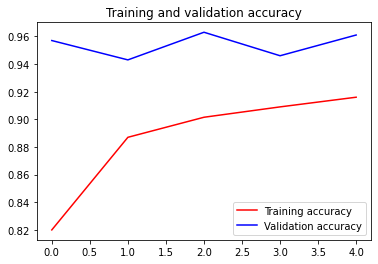

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<ipython-input-25-29cad73b0f0a>:45: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


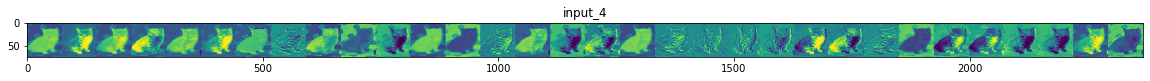

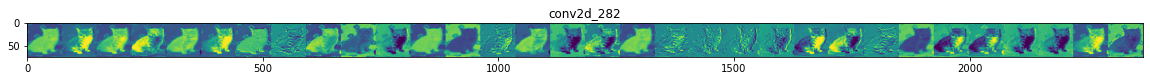

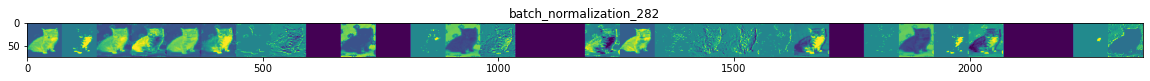

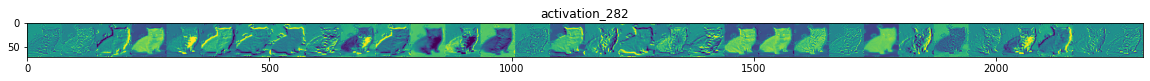

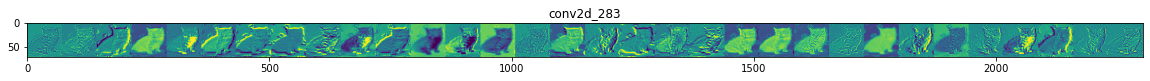

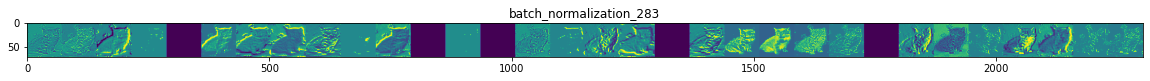

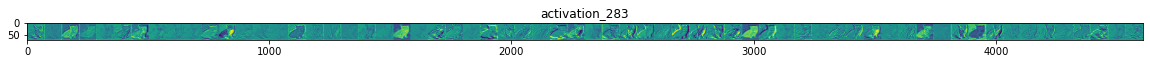

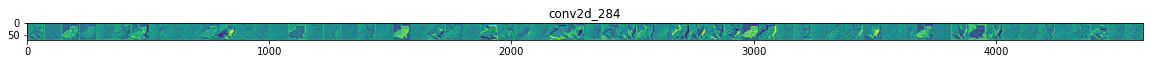

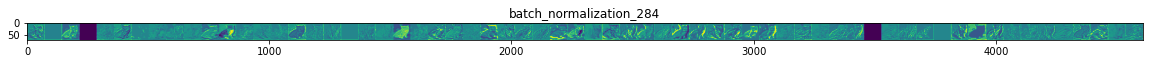

In [25]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# window环境os.path.join中间会加\\
cat_img_files = [train_cats_dir+"/"+f for f in train_cat_fnames]
dog_img_files = [train_dogs_dir+"/"+f for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps[0:9]):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________